In [1]:
import numpy as np
# import plotly
import tifffile
import matplotlib.pyplot as plt
import stackview

def plot_volume_plotly(optical_info, voxels_in=None, opacity=0.5, colormap='gray', fig=None):
    '''Plots a 3D array with the non-zero voxels shaded.'''
    voxels = voxels_in * 1.0
    # Check if this is a torch tensor
    if not isinstance(voxels_in, np.ndarray):
        try:
            voxels = voxels.detach()
            voxels = voxels.cpu().abs().numpy()
        except:
            pass
    voxels = np.abs(voxels)
    err = ("The set of voxels are expected to have non-zeros values. If the " +
        "BirefringentVolume was cropped to fit into a region, the non-zero values " +
        "may no longer be included.")
    assert voxels.any(), err

    import plotly.graph_objects as go
    volume_shape = optical_info['volume_shape']
    volume_size_um = [optical_info['voxel_size_um'][i] * optical_info['volume_shape'][i] for i in range(3)]
    # Define grid
    coords = np.indices(np.array(voxels.shape)).astype(float)
    # Shift by half a voxel and multiply by voxel size
    coords = [(coords[i]+0.5) * optical_info['voxel_size_um'][i] for i in range(3)]
    if fig is None:
        fig = go.Figure()
    fig.add_volume(
        x=coords[0].flatten(),
        y=coords[1].flatten(),
        z=coords[2].flatten(),
        value=voxels.flatten() / voxels.max(),
        isomin=0,
        isomax=0.1,
        opacity=opacity, # needs to be small to see through all surfaces
        surface_count=20, # needs to be a large number for good volume rendering
        # colorscale=colormap
        )
    camera = {'eye': {'x': 50, 'y': 0, 'z': 0}}
    fig.update_layout(
        scene=dict(
            xaxis = {"nticks": volume_shape[0], "range": [0, volume_size_um[0]]},
            yaxis = {"nticks": volume_shape[1], "range": [0, volume_size_um[1]]},
            zaxis = {"nticks": volume_shape[2], "range": [0, volume_size_um[2]]},
            xaxis_title='Axial dimension',
            aspectratio = {"x": volume_size_um[0], "y": volume_size_um[1], "z": volume_size_um[2]},
            aspectmode = 'manual'
            ),
        scene_camera=camera,
        margin={'r': 0, 'l': 0, 'b': 0, 't': 0},
        autosize=True
        )
    # fig.data = fig.data[::-1]
    # fig.show()
    return fig

def plot_lines_plotly(self, colormap='Bluered_r', size_scaler=5,
                        fig=None, draw_spheres=True, delta_n_ths=0.1):
    '''Plots the optic axis as lines and the birefringence as sphere
    at the ends of the lines. Other parameters could be opacity=0.5 or mode='lines'
    '''

    # Fetch local data
    delta_n = self.get_delta_n() * 1
    optic_axis = self.get_optic_axis() * 1
    optical_info = self.optical_info

    # Check if this is a torch tensor
    if not isinstance(delta_n, np.ndarray):
        try:
            delta_n = delta_n.cpu().detach().numpy()
            optic_axis = optic_axis.cpu().detach().numpy()
        except:
            pass

    delta_n /= np.max(np.abs(delta_n))
    delta_n[np.abs(delta_n)<delta_n_ths] = 0

    import plotly.graph_objects as go
    volume_shape = optical_info['volume_shape']
    volume_size_um = [optical_info['voxel_size_um'][i] * optical_info['volume_shape'][i] for i in range(3)]
    [dz, dxy, dxy] = optical_info['voxel_size_um']
    # Define grid
    coords = np.indices(np.array(delta_n.shape)).astype(float)

    coords_base = [(coords[i] + 0.5) * optical_info['voxel_size_um'][i] for i in range(3)]
    coords_tip =  [(coords[i] + 0.5 + optic_axis[i,...] * delta_n * 0.75) * optical_info['voxel_size_um'][i] for i in range(3)]

    # Plot single line per voxel, where it's length is delta_n
    z_base, y_base, x_base = coords_base
    z_tip, y_tip, x_tip = coords_tip

    # Don't plot zero values
    mask = delta_n==0
    x_base[mask] = np.NaN
    y_base[mask] = np.NaN
    z_base[mask] = np.NaN
    x_tip[mask] = np.NaN
    y_tip[mask] = np.NaN
    z_tip[mask] = np.NaN

    # Gather all rays in single arrays, to plot them all at once, placing NAN in between them
    array_size = 3 * len(x_base.flatten())
    # Prepare colormap
    all_x = np.empty((array_size))
    all_x[::3] = x_base.flatten()
    all_x[1::3] = x_tip.flatten()
    all_x[2::3] = np.NaN
    all_y = np.empty((array_size))
    all_y[::3] = y_base.flatten()
    all_y[1::3] = y_tip.flatten()
    all_y[2::3] = np.NaN
    all_z = np.empty((array_size))
    all_z[::3] = z_base.flatten()
    all_z[1::3] = z_tip.flatten()
    all_z[2::3] = np.NaN
    # Compute colors
    all_color = np.empty((array_size))
    all_color[::3] =    (x_base-x_tip).flatten() ** 2 + \
                        (y_base-y_tip).flatten() ** 2 + \
                        (z_base-z_tip).flatten() ** 2
    # all_color[::3] =  delta_n.flatten() * 1.0
    all_color[1::3] = all_color[::3]
    all_color[2::3] = 0
    all_color[np.isnan(all_color)] = 0

    err = ("The BirefringentVolume is expected to have non-zeros values. If the " +
        "BirefringentVolume was cropped to fit into a region, the non-zero values " +
        "may no longer be included.")
    assert any(all_color != 0), err

    all_color[all_color!=0] -= all_color[all_color!=0].min()
    all_color += 0.5
    all_color /= all_color.max()

    if fig is None:
        fig = go.Figure()
    fig.add_scatter3d(z=all_x, y=all_y, x=all_z,
        marker={"color": all_color, "colorscale": colormap, "size": 4},
        line={"color": all_color, "colorscale": colormap, "width": size_scaler},
        connectgaps=False,
        mode='lines'
        )
    if draw_spheres:
        fig.add_scatter3d(z=x_base.flatten(), y=y_base.flatten(), x=z_base.flatten(),
            marker={"color": all_color[::3] - 0.5,
                    "colorscale": colormap,
                    "size": size_scaler * 5 * all_color[::3]},
            line={"color": all_color[::3] - 0.5, "colorscale": colormap, "width": 5},
            mode='markers')
    camera = {'eye': {'x': 50, 'y': 0, 'z': 0}}
    fig.update_layout(
        scene=dict(
            xaxis = {"nticks": volume_shape[0], "range": [0, volume_size_um[0]]},
            yaxis = {"nticks": volume_shape[1], "range": [0, volume_size_um[1]]},
            zaxis = {"nticks": volume_shape[2], "range": [0, volume_size_um[2]]},
            xaxis_title = 'Axial dimension',
            aspectratio = {"x": volume_size_um[0], "y": volume_size_um[1], "z": volume_size_um[2]},
            aspectmode = 'manual'
            ),
        scene_camera=camera,
        margin={'r': 0, 'l': 0, 'b': 0, 't': 0},
        )
    # fig.data = fig.data[::-1]
    # fig.show()
    return fig



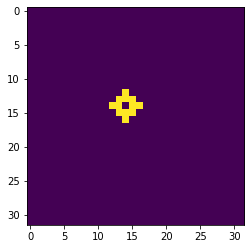

In [2]:
DATA_PATH = "/mnt/efs/shared_data/restorators/spheres"
obj = tifffile.imread(DATA_PATH + '/objects/0001_sphere.tiff')
delta_n = obj[0, ...]
optic_axis = obj[1:3, ...]
plt.imshow(delta_n[4, ...])
plt.show(block=True)
plt.pause(0.2)

In [3]:
%%html
<style>
.python-iframe > iframe {
  height:1000px !important;
}
</style>

In [4]:
%%html
<style>
.python-iframe > iframe {
  height:1000px !important;
}
</style>

In [5]:
stackview.slice(delta_n, continuous_update=True, zoom_factor=10)

In [6]:
# from ipywidgets import Image
# img_delta = Image(value=delta_n[4, ...])

In [ ]:
delta_n.layout.width = '100%'

In [8]:
stackview.orthogonal(delta_n, continuous_update=True, zoom_factor=10)

In [ ]:
volume_shape = [8, 32, 32]
volume_size_um = [1 * volume_shape[i] for i in range(3)]

In [ ]:
voxels = np.abs(delta_n)
# Define grid
coords = np.indices(np.array(voxels.shape)).astype(float)
# Shift by half a voxel and multiply by voxel size
coords = [(coords[i]+0.5) * volume_size_um[i] for i in range(3)]
fig = None
if fig is None:
    fig = go.Figure()
fig.add_volume(
    x=coords[0].flatten(),
    y=coords[1].flatten(),
    z=coords[2].flatten(),
    value=voxels.flatten() / voxels.max(),
    isomin=0,
    isomax=0.1,
    opacity=0.1, # needs to be small to see through all surfaces
    surface_count=20, # needs to be a large number for good volume rendering
    # colorscale=colormap
    )

In [19]:
'''Script to test a trained model on the set of birefringence data'''
import torch
from Data import BirefringenceDataset
from model_bir import BirNetwork

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"using {device} device")

saved_model_dir = "/mnt/efs/shared_data/restorators/models_bir/"

DATA_PATH = "/mnt/efs/shared_data/restorators/spheres"
test_data = BirefringenceDataset(DATA_PATH, split='test')
testloader = torch.utils.data.DataLoader(test_data, batch_size=1,
                                         shuffle=False, num_workers=2)

model_relu = BirNetwork().to(device)
model_relu.eval()
weights_relu = torch.load(saved_model_dir + 'sphere128.pt')
model_relu.load_state_dict(weights_relu)

model_leaky = BirNetwork().to(device)
model_leaky.eval()
weights_leaky = torch.load(saved_model_dir + 'sphere_9_2_epoch81.pt')
model_leaky.load_state_dict(weights_relu)

data_pair = test_data[0]
source = data_pair[0]
source = source.unsqueeze(axis=0).to(device)
# source1 = source1
with torch.no_grad():
    target_pred_relu = model_relu(source).cpu()

using cuda device


In [20]:
pred = target_pred_relu.squeeze(axis=0)
delta_pred = pred[0, ...].detach().numpy()

In [21]:
stackview.orthogonal(delta_pred, continuous_update=True, zoom_factor=10)

In [ ]:
target = data_pair[1]
delta_gt = target[0, ...]
stackview.orthogonal(delta_gt, continuous_update=True, zoom_factor=10)